In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
plt.rcParams['font.sans-serif']=['SimHei']

In [170]:
threshold_order, threshold_interval= 10, 1400
rule, rulename = '1D', '天'

In [2]:
data1 = pd.read_excel('../data/recycle_data_2018.xlsx')
data2 = pd.read_excel('../data/recycle_data_2019.xlsx')

In [3]:
data2.columns = data1.columns
data = data1.append(data2)
data = data.reset_index(drop=True)
data.shape

(1095368, 5)

In [4]:
categories = {'冰箱':('冰箱',), '空调':('空调',), '洗衣机':('洗衣机',), '电视':('电视',), '电脑':('电脑',), '小家电':('小家电',), '五金':('五金')}

In [5]:
def cate_match(catename, xcatelist):
    for cate in xcatelist:
        if catename in cate:
            return True
    return False

def classify_on(x, p):
    fg, catebelong = 0, None
    xcatelist = x[p].strip().split(',')
    for cate in categories.keys():
        for catename in categories[cate]:
            if cate_match(catename, xcatelist):
                fg = fg + 1
                catebelong = cate
                break
    if fg == 1:
        return catebelong
    return 'Others'

def classify(x):
    # p: 0 品类分， 1 规格分
    cate1 = classify_on(x, '品类')
    if cate1 != 'Others': return cate1
    cate2 = classify_on(x, '规格')
    if cate2 != 'Others': return cate2
    return 'Others' 

In [6]:
data['catebelong'] = data.apply(classify, axis=1)

In [7]:
catecount = pd.DataFrame()
catecount['条目'] = data.groupby('catebelong')[['数量']].count()
catecount['总量'] = data.groupby('catebelong')[['数量']].sum()
catecount = catecount.sort_values('总量', ascending=False)

In [8]:
catecount.index

Index(['电视', '冰箱', '洗衣机', '空调', '电脑', '小家电', '五金', 'Others'], dtype='object', name='catebelong')

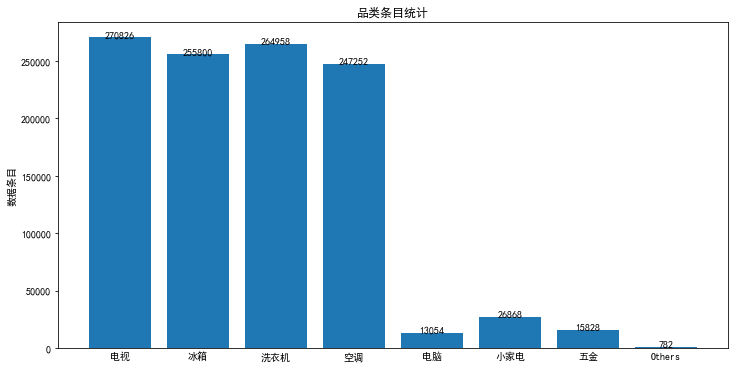

In [126]:
plt.figure(figsize=(12, 6))
plt.rcParams['font.sans-serif']=['SimHei']
rect1 = plt.bar(range(len(catecount)), catecount['条目'])
for i, rect in enumerate(rect1):
    height = rect.get_height()
    plt.text(rect.get_x()+rect.get_width()/2,height+30,str(height),ha='center')
    plt.text(rect.get_x()+rect.get_width()/2,-10000,str(catecount.index[i]),ha='center')
plt.xticks([])
plt.ylabel('数据条目')
plt.title('品类条目统计')
plt.savefig('./figures/品类条目统计.png', bbox_inches='tight', dpi=480)
plt.show()

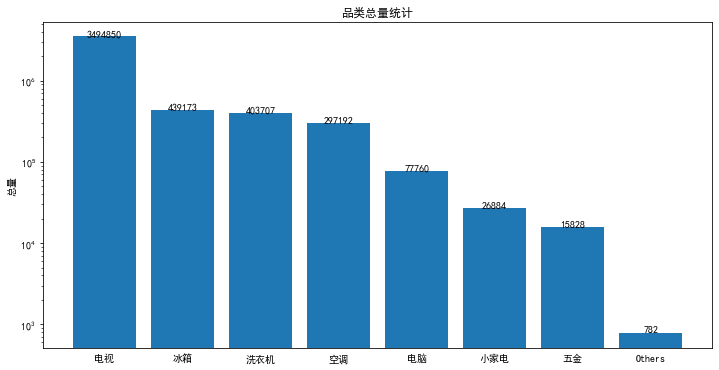

In [128]:
plt.figure(figsize=(12, 6))
plt.rcParams['font.sans-serif']=['SimHei']
rect1 = plt.bar(range(len(catecount)), catecount['总量'])
for i, rect in enumerate(rect1):
    height = rect.get_height()
    plt.text(rect.get_x()+rect.get_width()/2,height+30,str(catecount['总量'][i]),ha='center')
    plt.text(rect.get_x()+rect.get_width()/2,350,str(catecount.index[i]),ha='center')
plt.xticks([])
plt.yscale('log')
plt.ylabel('总量')
plt.title('品类总量统计')
plt.savefig('./figures/品类总量统计.png', bbox_inches='tight', dpi=480)
plt.show()

In [163]:
def order_series(catedata, rule='1D', threshold_order=99999, threshold_interval=99999):
    catedata = catedata[catedata['数量'] <= threshold_order]
    datedata = catedata.resample(rule = '1D', on = '下单时间',).sum()
    datedata = datedata[datedata['数量'] <= threshold_interval]
    if rule == '1W': datedata = datedata.resample(rule = '1W').sum()
    dateindex = pd.date_range('20180101','20191231', freq=rule)
    data_fill = []
    for i in dateindex:
        if i not in datedata.index:
            data_fill.append(0)
        else:
            data_fill.append(datedata.loc[i]['数量'])
    data_all = pd.Series(data_fill, dateindex)
    return data_all

In [171]:
def plot_order(ax, cate, catedata, rule='1D', threshold_order=99999, threshold_interval=99999):
    data_all = order_series(catedata, rule, threshold_order, threshold_interval)
    ax.plot(range(len(data_all)), data_all)
    ax.set_title(cate)

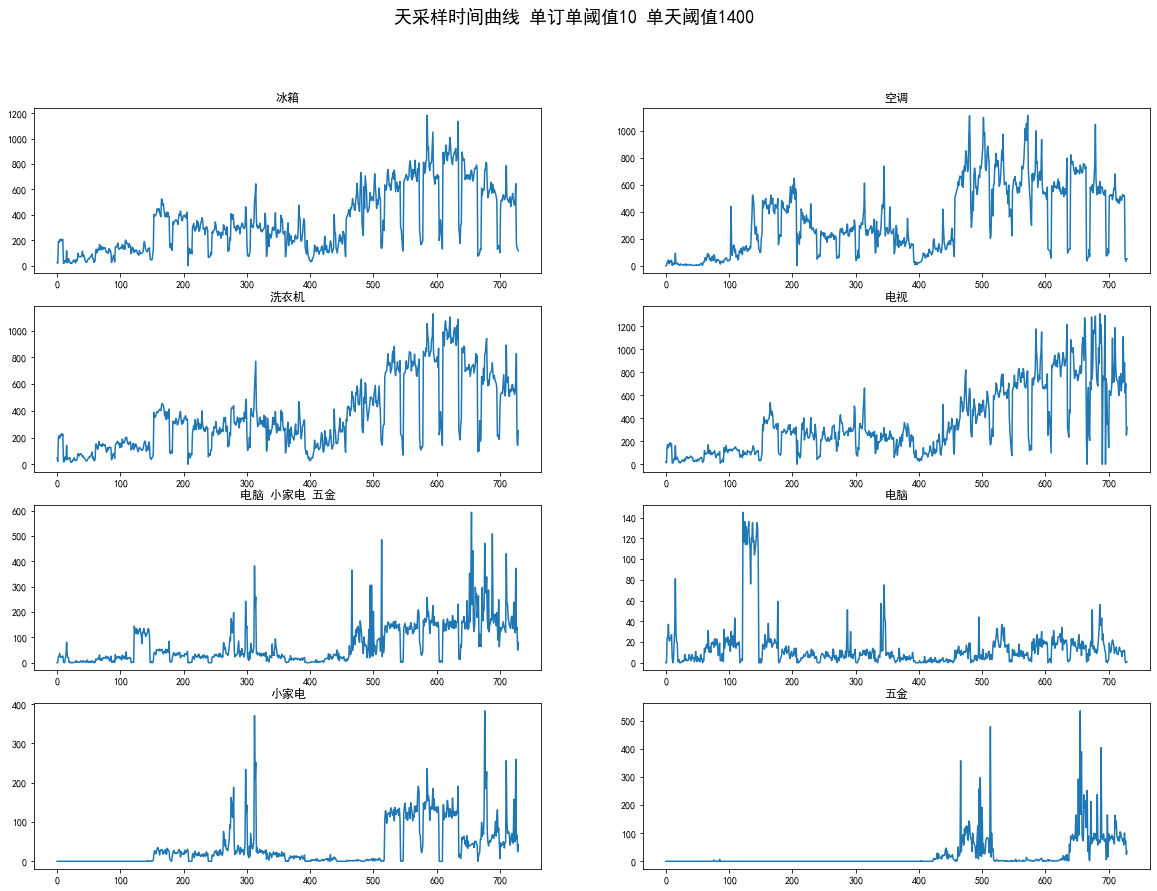

In [172]:
plt.figure(figsize=(20, 14))
catelist = list(categories.keys())
catelist.insert(4, 'Union')
for idx, cate in enumerate(catelist):
    if cate != 'Union':
        catedata = data[data['catebelong'] == cate]
    else:
        catedata = data[(data['catebelong'] == catelist[-3]) | (data['catebelong'] == catelist[-2]) | (data['catebelong'] == catelist[-1])]
        cate = catelist[-3] + ' ' + catelist[-2] + ' ' + catelist[-1]
    ax = plt.subplot(4, 2, idx+1)
    plot_order(ax, cate, catedata, rule, threshold_order, threshold_interval)
title = rulename + '采样时间曲线 单订单阈值' + (str(threshold_order) if threshold_order < 99999 else 'None') + ' 单天阈值' + (str(threshold_interval) if threshold_interval < 99999 else 'None')
plt.suptitle(title, fontsize=18)
# plt.savefig('./figures/{}.png'.format(title),bbox_inches='tight', dpi=480)
plt.show()

In [89]:
catedata = data[data['catebelong']=='电脑']
catedata = catedata[catedata['数量'] <= threshold_order]
datedata = catedata.resample(rule = rule, on = '下单时间',).sum()
catedata['下单时间'].min()
catedata = catedata.sort_values('下单时间')
catedata.to_excel('./233.xlsx')

In [158]:
data.to_csv('../data/recycle_all.csv',index=None)

In [155]:
datadd = pd.read_csv('./recycle.csv')

In [190]:
cate_series_data = pd.DataFrame(index=pd.date_range('20180101','20191231', freq=rule))
# cate_series_data['dataindex'] = pd.date_range('20180101','20191231', freq=rule)
catelist = list(categories.keys())
catelist.insert(4, 'Union')
for cate in catelist:
    if cate != 'Union':
        catedata = data[data['catebelong'] == cate]
    else:
        catedata = data[(data['catebelong'] == catelist[-3]) | (data['catebelong'] == catelist[-2]) | (data['catebelong'] == catelist[-1])]
        cate = catelist[-3] + ' ' + catelist[-2] + ' ' + catelist[-1]
    seriesdata = order_series(catedata, rule, threshold_order, threshold_interval)
    cate_series_data[cate] = seriesdata

In [18]:
df_raw = pd.read_csv('../data/recycle_all.csv', parse_dates=['下单时间'])

In [25]:
df_raw[df_raw['地址'].str.contains('北京')].resample('1D', on='下单时间').sum()

,数量
下单时间,
2018-01-01,100
2018-01-02,0
2018-01-03,3
2018-01-04,2
2018-01-05,0
...,...
2019-12-27,9
2019-12-28,13
2019-12-29,4


In [72]:
df_2018 = pd.read_csv('../data/cate_series_data2018.csv',index_col=0)

In [73]:
L, R = 0, int((len(df_2018) - 28) * 0.9)
df_train = df_2018[:303][['冰箱', '空调', '洗衣机', '电视']]

In [74]:
df_train.describe()

,冰箱,空调,洗衣机,电视
count,303.000000,303.000000,303.000000,303.000000
mean,200.531353,189.250825,195.082508,174.663366
std,130.075646,166.325689,123.309670,121.940976
min,0.000000,0.000000,0.000000,0.000000
25%,95.500000,38.000000,86.000000,75.500000
50%,158.000000,150.000000,159.000000,130.000000
75%,307.500000,286.000000,303.500000,280.000000
max,525.000000,648.000000,487.000000,536.000000


In [52]:
df_raw = pd.read_csv('../data/cate_series_data2019.csv', parse_dates=['时间'])
df_raw.head()

,时间,冰箱,空调,洗衣机,电视,电脑 小家电 五金,电脑,小家电,五金
0,2019-01-01,337,276,314,216,2,2,0,0
1,2019-01-02,159,148,131,78,3,2,1,0
2,2019-01-03,253,227,259,154,14,5,9,0
3,2019-01-04,198,134,156,152,13,5,8,0
4,2019-01-05,218,188,234,188,28,14,14,0


In [53]:
df_new = pd.DataFrame()
df_new['时间'] = df_raw['时间']

In [54]:
for cate in df_raw.columns[1:]:
    df_new[cate] = df_raw.apply(lambda row: df_raw[max(0, row.name - 6): row.name+1][cate].sum(), 1)

In [69]:
df_new = pd.read_csv('../data/cate_series_data2019.csv')

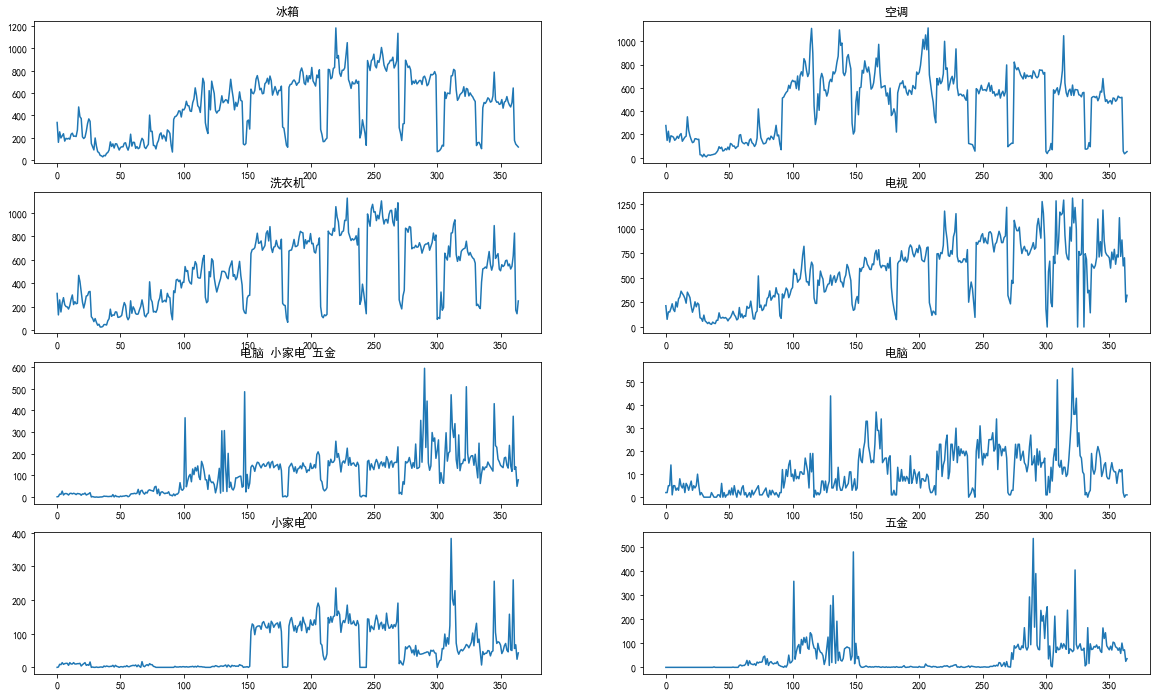

In [71]:
plt.figure(figsize=(20, 12))
for i, cate in enumerate(df_new.columns[1:]):
    ax = plt.subplot(4, 2, i+1)
    data_all = df_new[cate].tolist()
    ax.plot(range(len(data_all)), data_all)
    ax.set_title(cate)
plt.show()

In [4]:
df_data_all = pd.read_csv('../data/cate_series_data.csv', parse_dates=['时间'])

In [5]:
df_raw1, df_raw2 = df_data_all[:365].reset_index(drop=True), df_data_all[-365:].reset_index(drop=True)

In [6]:
df_raw1[140:160]

,时间,冰箱,空调,洗衣机,电视,电脑 小家电 五金,电脑,小家电,五金
140,2018-05-21,125,335,155,112,104,104,0,0
141,2018-05-22,119,234,97,85,108,108,0,0
142,2018-05-23,111,237,130,93,114,114,0,0
143,2018-05-24,110,288,135,106,124,122,2,0
144,2018-05-25,137,190,107,116,135,135,0,0
145,2018-05-26,128,232,167,110,131,131,0,0
146,2018-05-27,140,182,140,117,106,106,0,0
147,2018-05-28,55,122,49,39,1,0,1,0
148,2018-05-29,46,115,44,29,1,0,1,0
149,2018-05-30,47,96,35,38,5,4,1,0


In [4]:
data_path = '../data/cate_data.csv'
features = ['冰箱', '空调', '洗衣机', '电视']

In [9]:
df_raw = pd.read_csv(data_path, parse_dates=['时间'])
df_data0 = df_raw[:365][features].reset_index(drop=True)[90:-15].reset_index(drop=True)
df_data1 = df_raw[-365:][features].reset_index(drop=True)[90:-15].reset_index(drop=True)
df_data0.describe()

,冰箱,空调,洗衣机,电视
mean,258.996923,267.013654,258.238462,230.368462
std,120.294199,149.823740,120.658285,117.472105
min,30.000000,22.000000,35.000000,19.000000
25%,140.000000,146.500000,153.750000,120.000000
50%,280.000000,247.000000,273.500000,245.500000
75%,344.250000,374.500000,343.250000,300.500000
max,644.000000,861.550000,771.000000,708.800000


In [20]:
df_data1.describe()[1:4].append(df_data1.describe()[-1:])

,冰箱,空调,洗衣机,电视
mean,592.684615,590.230769,618.226923,664.798654
std,225.364656,215.142120,249.477412,268.844615
min,72.000000,35.000000,68.000000,75.000000
max,1184.000000,1115.000000,1126.000000,1309.000000
